In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os,time,datetime,sys

### 1D Inviscid Euler Equation

$$

\begin{aligned}
&\partial_t U + \nabla\cdot f(U)=0, \quad  x\in\Omega\subset\mathbb{R},t\in(0,T] \\

& U = \begin{bmatrix}
\rho \\
\rho u
\end{bmatrix}
\quad
f(U) = \begin{bmatrix}
\rho u\\
\rho u^2 +p 
\end{bmatrix} \\
\\
&\text{BC/IC}\\
&\qquad U(-1,t) = U(1,t), \quad \nabla U(-1,t)=\nabla U(1,t)\\
&\qquad U_0 = (\rho_0,u_0,p_0) = (1+0.2\sin(\pi x),1,1)\\

&\text{exact solution} \\
&\qquad U = (\rho,u,p) = (1+0.2\sin(\pi(x-t)),1,1)\\

\end{aligned}

$$


### PINNs Model

In [2]:
class PINN(tf.keras.Model):
    def __init__(
            self,
            t,x,u,t_r,x_r,lb,ub,
            in_dim,out_dim,width,depth,
            activ="tanh",w_init="glorot_normal",b_init="zeros",
            lr=1e-3,opt="Adam",weight_data=1.,weight_pde=1.,
            info_seed=1234):
        super().__init__()
        # information
        self.info_seed = info_seed
        # initial the data
        self.data_type = tf.float32
        self.x = tf.convert_to_tensor(x,dtype=self.data_type)
        self.t = tf.convert_to_tensor(t,dtype=self.data_type)
        self.u = tf.convert_to_tensor(u,dtype=self.data_type)
        # pde loss train point = inner + outer(initial+boundary)
        t_r = tf.concat([t,t_r],axis=0)
        x_r = tf.concat([x,x_r],axis=0)
        self.x_r = tf.convert_to_tensor(x_r,dtype=self.data_type)
        self.t_r = tf.convert_to_tensor(t_r,dtype=self.data_type)
        self.lb = tf.convert_to_tensor(lb,dtype=self.data_type)
        self.ub = tf.convert_to_tensor(ub,dtype=self.data_type)
        self.nu = tf.constant(0.01/np.pi,dtype=self.data_type)
        # neuron network configuration
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.width = width
        self.depth = depth
        self.activ = activ
        self.w_init = w_init
        self.b_init = b_init
        self.lr = lr
        self.opt = opt
        self.weight_data = weight_data
        self.weight_pde = weight_pde
        
        # call
        self.dnn = self.dnn_init(in_dim,out_dim,width,depth)
        self.params = self.dnn.trainable_variables
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

        # track loss
        self.ep_log = []
        self.loss_log = []

        print(">>>>> start time:", datetime.datetime.now())
        print(">>>>> configuration;")
        print("         dtype        :", self.data_type)
        print("         activ func   :", self.activ)
        print("         weight init  :", self.w_init)
        print("         learning rate:", self.lr)
        print("         optimizer    :", self.opt)
        print("         summary      :", self.dnn.summary())
    
    def dnn_init(self,in_dim,out_dim,width,depth):
        net = tf.keras.Sequential()
        net.add(tf.keras.layers.InputLayer(in_dim))
        # net.add(tf.keras.layers.Lambda(lambda x: 2. * (x - self.lb) / (self.ub - self.lb) - 1.))
        for l in range(depth - 1):
            net.add(tf.keras.layers.Dense(units=width, activation = self.activ,kernel_initializer = self.w_init, bias_initializer = self.b_init, ))
        net.add(tf.keras.layers.Dense(out_dim))
        return net
    
    def loss_pde(self):
        with tf.GradientTape(persistent=True) as tp:
            tp.watch(self.t_r)
            tp.watch(self.x_r)
            u = self.dnn(tf.concat([self.t_r,self.x_r],1))
            u_t = tp.gradient(u,self.t_r)
            u_x = tp.gradient(u,self.x_r)
        u_xx = tp.gradient(u_x,self.x_r)
        del tp
        gv = u_t + u * u_x - self.nu * u_xx
        r = tf.reduce_mean(tf.square(gv))
        return r
    
    def loss_icbc(self):
        u_nn = self.dnn(tf.concat([self.t,self.x],1))
        return tf.reduce_mean(tf.square(self.u-u_nn))
    
    @tf.function
    def grad_desc(self):
        with tf.GradientTape() as tp:
            loss = self.loss_pde() + self.loss_icbc()
        grad = tp.gradient(loss,self.params)
        del tp
        self.optimizer.apply_gradients(zip(grad,self.params))
        return loss
    
    def train(self,epoch,tol,info_freq):
        print(">>>>> training setting;")
        print("         # of epoch     :", epoch)
        print("         convergence tol:", tol)
        t0 = time.time()
        for ep in range(epoch+1):
            ep_loss = self.grad_desc()
            if ep % info_freq ==0:
                elps = time.time() -t0
                self.ep_log.append(ep)
                self.loss_log.append(ep_loss)
                print("ep: %d, loss: %.3e, elps: %.3f" % (ep, ep_loss, elps))
                t0 = time.time()
            if ep_loss < tol:
                print(">>>>> end time:", datetime.datetime.now())
                break
        print(">>>>> end time:", datetime.datetime.now())

    def predict(self,t,x):
        t = tf.convert_to_tensor(t,dtype=self.data_type)
        x = tf.convert_to_tensor(x,dtype=self.data_type)
        with tf.GradientTape(persistent=True) as tp:
            tp.watch(t)
            tp.watch(x)
            u = self.dnn(tf.concat([t,x],1))
            u_t = tp.gradient(u,t)
            u_x = tp.gradient(u,x)
        u_xx = tp.gradient(u_x,x)
        gv = u_t + u * u_x - self.nu * u_xx
        return u,gv

### Structure of the Costum PINNs

In [14]:
in_dim = 2
out_dim = 1
width = 20
depth = 7

epoch = 8000
tol = 1e-8

N_0 = 50
N_b = 50
N_r = 2000

w_init = "glorot_normal"
b_init = "zeros"
act = "tanh"

lr = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = 5e-3,
    decay_steps = epoch,
    alpha = 1e-2
)

opt = "Adam"
info_freq = 500
info_seed = 1234

weight_data = 1.
weight_pde = 1.

print("python    :", sys.version)
print("tensorflow:", tf.__version__)
print("rand seed :", info_seed)
os.environ["PYTHONHASHSEED"] = str(info_seed)

python    : 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
tensorflow: 2.9.1
rand seed : 1234


### Data for Burgers equation

$$
\begin{aligned}
&u_t+uu_x−(0.01/\pi)u_{xx}=0,   x\in[−1,1],   t\in[0,1] \\
&u(0,x)=−sin(\pi x)\\
&u(t,−1)=u(t,1)=0
\end{aligned}
$$

In [20]:
tmin, tmax =  0., 1.
xmin, xmax = -1., 1.
lb = tf.constant([tmin, xmin], dtype = tf.float32)
ub = tf.constant([tmax, xmax], dtype = tf.float32)

t_0 = tf.ones((N_0, 1), dtype = tf.float32) * lb[0]
x_0 = tf.random.uniform((N_0, 1), lb[1], ub[1], dtype = tf.float32)
t_b = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype = tf.float32)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b, 1), .5, dtype = tf.float32)
t_r = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype = tf.float32)
x_r = tf.random.uniform((N_r, 1), lb[1], ub[1], dtype = tf.float32)

# initial and boundary
u_0 = -tf.sin(np.pi*x_0)
u_b = tf.zeros((x_b.shape[0],1),dtype=tf.float32)

t = tf.concat([t_0,t_b],axis=0)
x = tf.concat([x_0,x_b],axis=0)
u = tf.concat([u_0,u_b],axis=0)


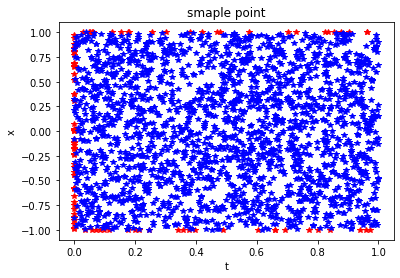

In [24]:
plt.ylabel("x")
plt.xlabel("t")
plt.title("smaple point")
plt.plot(t_0,x_0,"*",color="r")
plt.plot(t_b,x_b,"*",color="r")
plt.plot(t_r,x_r,"*",color="b")
plt.savefig("sample point")

In [15]:
pinn = PINN(t,x,u,t_r,x_r,lb,ub,
            in_dim,out_dim,width,depth,
            act,w_init,b_init,
            lr,opt,weight_data,weight_pde,
            info_seed)

>>>>> start time: 2022-07-14 12:26:19.623007
>>>>> configuration;
         dtype        : <dtype: 'float32'>
         activ func   : tanh
         weight init  : glorot_normal
         learning rate: <keras.optimizers.schedules.learning_rate_schedule.CosineDecay object at 0x000001FC06BA4040>
         optimizer    : Adam
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 20)                60        
                                                                 
 dense_8 (Dense)             (None, 20)                420       
                                                                 
 dense_9 (Dense)             (None, 20)                420       
                                                                 
 dense_10 (Dense)            (None, 20)                420       
                                                              

In [6]:
pinn.train(epoch,tol,info_freq)

>>>>> training setting;
         # of epoch     : 8000
         convergence tol: 1e-08
ep: 0, loss: 3.361e-01, elps: 1.528
ep: 500, loss: 3.818e-02, elps: 3.177
ep: 1000, loss: 9.244e-02, elps: 3.173
ep: 1500, loss: 2.074e-02, elps: 3.175
ep: 2000, loss: 1.793e-02, elps: 3.736
ep: 2500, loss: 4.929e-03, elps: 4.177
ep: 3000, loss: 5.497e-03, elps: 4.065
ep: 3500, loss: 1.373e-03, elps: 4.031
ep: 4000, loss: 1.031e-03, elps: 4.552
ep: 4500, loss: 8.495e-04, elps: 4.196
ep: 5000, loss: 7.361e-04, elps: 4.118
ep: 5500, loss: 6.454e-04, elps: 4.525
ep: 6000, loss: 5.806e-04, elps: 4.426
ep: 6500, loss: 5.320e-04, elps: 4.595
ep: 7000, loss: 4.989e-04, elps: 5.114
ep: 7500, loss: 4.798e-04, elps: 4.278
ep: 8000, loss: 4.699e-04, elps: 4.537
>>>>> end time: 2022-07-14 10:54:30.529199


### Visualization

In [7]:
def plot_loss(x,y,title,savepath="./pics"):
    # plt.figure(figsize=(8,4))
    fig1,ax1 = plt.subplots(1)
    ax1.plot(x,y)
    ax1.grid(alpha=0.5)
    ax1.set_ylabel("loss")
    ax1.set_xlabel("epoch")
    ax1.set_title("train loss")

    # plt.figure(figsize=(8,4))
    fig2,ax2 = plt.subplots(1)
    ax2.plot(x,y)
    ax2.grid(alpha=0.5)
    ax2.set_ylabel("loss")
    ax2.set_xlabel("epoch")
    ax2.set_title("train loss(log)")

    # plt.figure(figsize=(8,4))
    fig3,ax3 = plt.subplots(1)
    strt = int(len(x)*0.7)
    ax3.plot(x[strt:],y[strt:])
    ax3.grid(alpha=0.5)
    ax3.set_xlabel("epoch")
    ax3.set_ylabel("loss")
    ax2.set_yscale("log")
    ax3.set_title("train loss(part)")

    if not os.path.exists(savepath):
        os.makedirs(savepath)
    fig1.savefig(savepath+"/"+title)
    fig2.savefig(savepath+"/"+title+"(log)")
    fig3.savefig(savepath+"/"+title+"(part")


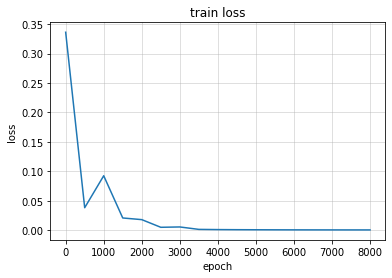

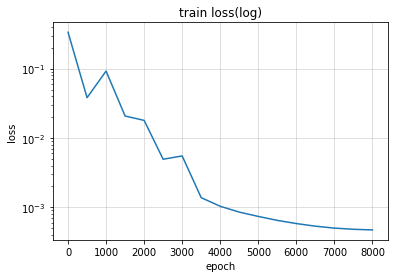

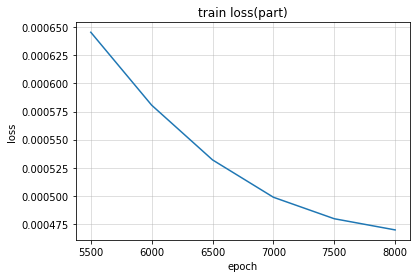

In [8]:
plot_loss(pinn.ep_log,pinn.loss_log,"loss")

In [9]:
def plot_solution(X,u,title,savepath="./pics"):
    lb = X.min(0)
    ub = X.max(0)
    x = np.linspace(lb[0],ub[0],200)
    y = np.linspace(lb[1],ub[1],200)
    x,y = np.meshgrid(x,y)
    phi = griddata(X,u.flatten(),(x,y),method="linear")
    plt.imshow(phi,interpolation='nearest',cmap='rainbow',extent=[0,1,-1,1],origin="lower",aspect="auto")
    plt.colorbar()
    plt.title(title)
    plt.xlabel('t')
    plt.ylabel('x')
    if not os.path.exists(savepath):
        os.makedirs(savepath)
    plt.savefig(savepath+'/'+title)
    

In [10]:
t = np.linspace(tmin,tmax,1001)
x = np.linspace(xmin,xmax,101)

t,x = np.meshgrid(t,x)
t = t.reshape(-1, 1)
x = x.reshape(-1, 1)
TX = np.c_[t,x]

In [11]:
u_hat,r_hat = pinn.predict(t,x)

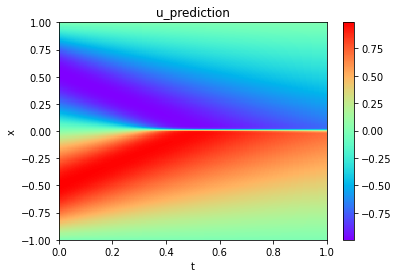

In [12]:
plot_solution(TX, u_hat.numpy(),title='u_prediction')

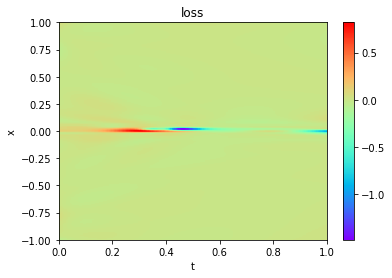

In [13]:
plot_solution(TX, r_hat.numpy(),title='loss')